## EcoPackAI – AI-Powered Sustainable Packaging Recommendation System

In [52]:
# Core libraries reading the data in both numrical and char
import pandas as pd
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models to train the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Data Loading

In [53]:
# Load materials dataset which is given by usha mam
df = pd.read_excel("materials_database_600.xlsx")

# For Quick look
df.head()

,Material_ID,Material_Name,Category,Density_kg_m3,Tensile_Strength_MPa,CO2_Emission_kg,Cost_per_kg,Biodegradable
0,1,Recycled Palm Leaf,Eco,489,13.19,0.235,1.06,Yes
1,2,Waterproof Palm Leaf,Eco,561,15.29,0.449,1.47,Yes
2,3,Single-Ply Kraft Paper,Paper,742,36.08,0.742,0.91,Yes
3,4,Single-Ply Aluminum Foil,Metal,2506,32.48,11.137,3.30,No
4,5,Fire-Retardant Nylon Fabric,Plastic,1323,69.04,6.800,4.71,No


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Material_ID           600 non-null    int64  
 1   Material_Name         600 non-null    object 
 2   Category              600 non-null    object 
 3   Density_kg_m3         600 non-null    int64  
 4   Tensile_Strength_MPa  600 non-null    float64
 5   CO2_Emission_kg       600 non-null    float64
 6   Cost_per_kg           600 non-null    float64
 7   Biodegradable         600 non-null    object 
dtypes: float64(3), int64(2), object(3)
memory usage: 37.6+ KB


## Exploratory Data Analysis (EDA) - to handle the missing values and Feature Engineering 

In [55]:
# Handle missing values
df = df.dropna()

df.dropna()

,Material_ID,Material_Name,Category,Density_kg_m3,Tensile_Strength_MPa,CO2_Emission_kg,Cost_per_kg,Biodegradable
0,1,Recycled Palm Leaf,Eco,489,13.19,0.235,1.06,Yes
1,2,Waterproof Palm Leaf,Eco,561,15.29,0.449,1.47,Yes
2,3,Single-Ply Kraft Paper,Paper,742,36.08,0.742,0.91,Yes
3,4,Single-Ply Aluminum Foil,Metal,2506,32.48,11.137,3.30,No
4,5,Fire-Retardant Nylon Fabric,Plastic,1323,69.04,6.800,4.71,No
...,...,...,...,...,...,...,...,...
595,596,Insulated Teflon Coating,Plastic,1084,14.78,9.459,12.61,No
596,597,UV-Stabilized Nylon Fabric,Plastic,1112,63.84,5.804,4.06,No
597,598,Laminated Recycled Denim,Eco,326,5.93,0.771,2.21,Yes
598,599,Double-Wall Bamboo Sheet,Wood,1004,77.42,0.803,3.21,Yes


In [56]:
# Encode categorical variables
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
df['Biodegradable'] = df['Biodegradable'].map({'Yes':1, 'No':0})

# Feature Engineering
df['CO2_Impact_Index'] = df['CO2_Emission_kg'] / df['Density_kg_m3']
df['Cost_Efficiency_Index'] = df['Tensile_Strength_MPa'] / df['Cost_per_kg']
df['Material_Suitability_Score'] = (
    df['Biodegradable']*2 + df['Cost_Efficiency_Index'] - df['CO2_Impact_Index']
)
le

LabelEncoder()

# Prepare ML Dataset
### Here prediction done on these two: Cost per kg (financial impact), CO2 emission (environmental impact)

In [57]:
X = df[['Density_kg_m3','Tensile_Strength_MPa','Category','Biodegradable']]
y_cost = df['Cost_per_kg']
y_co2 = df['CO2_Emission_kg']

# Train-test split
X_train, X_test, y_cost_train, y_cost_test = train_test_split(X, y_cost, test_size=0.2, random_state=42)
_, _, y_co2_train, y_co2_test = train_test_split(X, y_co2, test_size=0.2, random_state=42)


## Model Fitting and Train Machine Learning Models

In [58]:
# Random Forest for Cost
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_cost_train)
y_cost_pred = rf_model.predict(X_test)

# XGBoost for CO2
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_co2_train)
y_co2_pred = xgb_model.predict(X_test)


## Evaluation of Models Metrics

In [59]:
def evaluate(y_true, y_pred, label):
    print(f"{label} Prediction:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R2:", r2_score(y_true, y_pred))
    print("-"*40)

evaluate(y_cost_test, y_cost_pred, "Cost")
evaluate(y_co2_test, y_co2_pred, "CO2")


Cost Prediction:
RMSE: 1.6246538262534576
MAE: 0.9283916666666667
R2: 0.3700757318267689
----------------------------------------
CO2 Prediction:
RMSE: 1.0510519013090829
MAE: 0.4788864164392154
R2: 0.8195189728274068
----------------------------------------


### Material Ranking System - Rank materials based on predicted low cost + low CO2 + high suitability score.

In [60]:
df['Predicted_Cost'] = rf_model.predict(X)
df['Predicted_CO2'] = xgb_model.predict(X)

df['Final_Rank_Score'] = (
    -df['Predicted_Cost'] - df['Predicted_CO2'] + df['Material_Suitability_Score']
)

recommendations = df.sort_values(by='Final_Rank_Score', ascending=False)
print(recommendations[['Material_Name','Predicted_Cost','Predicted_CO2','Final_Rank_Score']].head(10))


                    Material_Name  Predicted_Cost  Predicted_CO2  \
374        Reinforced Steel Strap          1.8276       3.473982   
238       Double-Wall Steel Strap          1.8173       2.445596   
179          Recycled Steel Strap          1.2229       1.260601   
267          Standard Steel Strap          1.3475       2.044389   
54         Heavy-Duty Steel Strap          1.8173       2.445596   
539  Commercial-Grade Steel Strap          1.3602       2.044389   
416       Lightweight Steel Strap          1.2671       1.747790   
288         Laminated Steel Strap          2.0352       2.680505   
543        Waterproof Steel Strap          1.4570       2.168312   
191     UV-Stabilized Steel Strap          1.8709       2.373813   

     Final_Rank_Score  
374        379.520552  
238        371.408740  
179        331.268639  
267        328.770456  
54         328.514646  
539        313.887463  
416        294.013393  
288        280.197785  
543        274.515277  
191        

## Visualization of Data

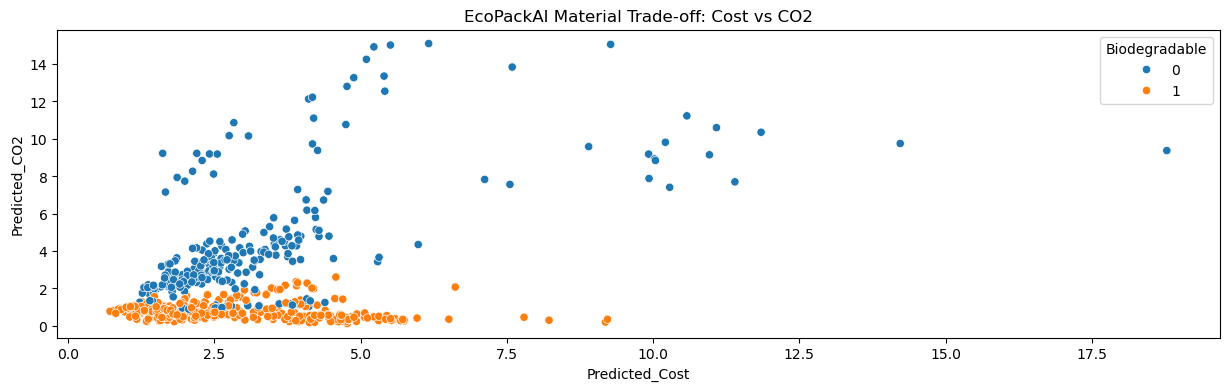

In [67]:
plt.figure(figsize=(15,4))
sns.scatterplot(x='Predicted_Cost', y='Predicted_CO2', hue='Biodegradable', data=df)
plt.title("EcoPackAI Material Trade-off: Cost vs CO2")
plt.show()


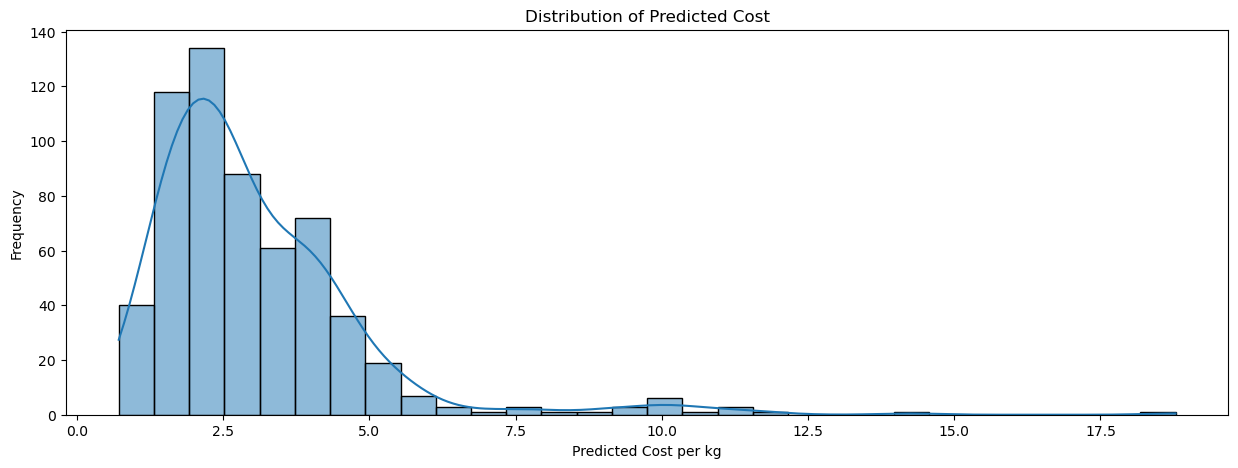

In [62]:
# Histogram of Predicted Cost
plt.figure(figsize=(15,5))
sns.histplot(df['Predicted_Cost'], bins=30, kde=True)
plt.title('Distribution of Predicted Cost')
plt.xlabel('Predicted Cost per kg')
plt.ylabel('Frequency')
plt.show()


## Additional plots to show result data


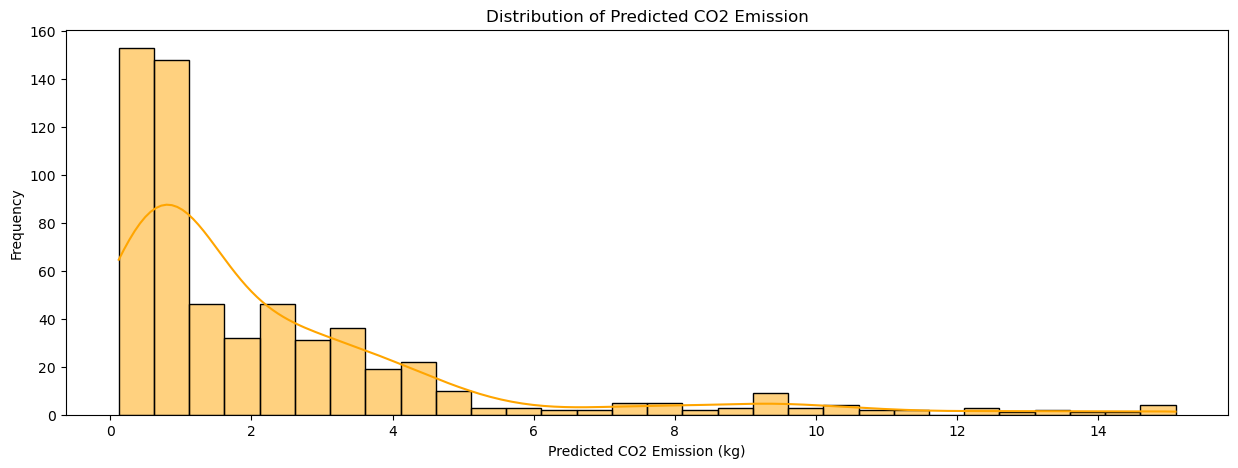

In [63]:
# Histogram of Predicted CO2 Emission
plt.figure(figsize=(15,5))
sns.histplot(df['Predicted_CO2'], bins=30, kde=True, color='orange')
plt.title('Distribution of Predicted CO2 Emission')
plt.xlabel('Predicted CO2 Emission (kg)')
plt.ylabel('Frequency')
plt.show()

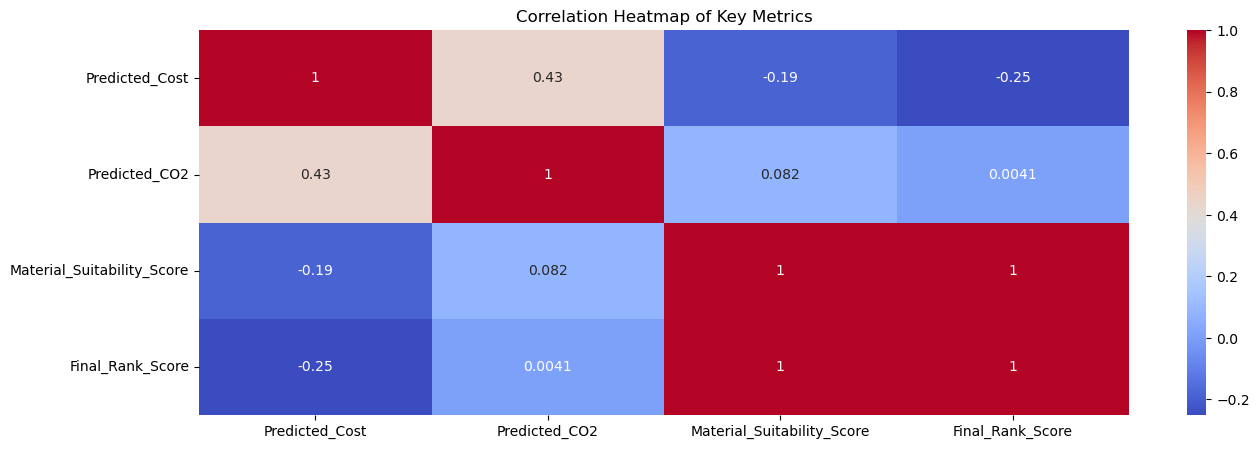

In [68]:
# Correlation Heatmap
plt.figure(figsize=(15,5))
sns.heatmap(df[['Predicted_Cost', 'Predicted_CO2', 'Material_Suitability_Score', 'Final_Rank_Score']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Key Metrics')
plt.show()